## Pretrained GAN

In [1]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'
print(path_hr)
print(path_lr)

C:\Users\caoyanjie\.fastai\data\oxford-iiit-pet\images
C:\Users\caoyanjie\.fastai\data\oxford-iiit-pet\crappy


### Crappified data

In [3]:
from PIL import Image, ImageDraw, ImageFont

In [4]:
# 把优质图片变成残次图
def crappify(fn, i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    w, h = img.size
    q = random.randint(10, 70)
    ImageDraw.Draw(img).text((random.randint(0, w//2), random.randint(0, h//2)), str(q), fill=(255, 255, 255))
    img.save(dest, quality=q)

In [5]:
#il = ImageList.from_folder(path_hr)
#parallel(crappify, il.items, max_workers=1)

In [6]:
bs, size = 32, 128
# bs, size = 24, 160
# bs, size = 8, 256
arch = models.resnet34

### Pre-train generator

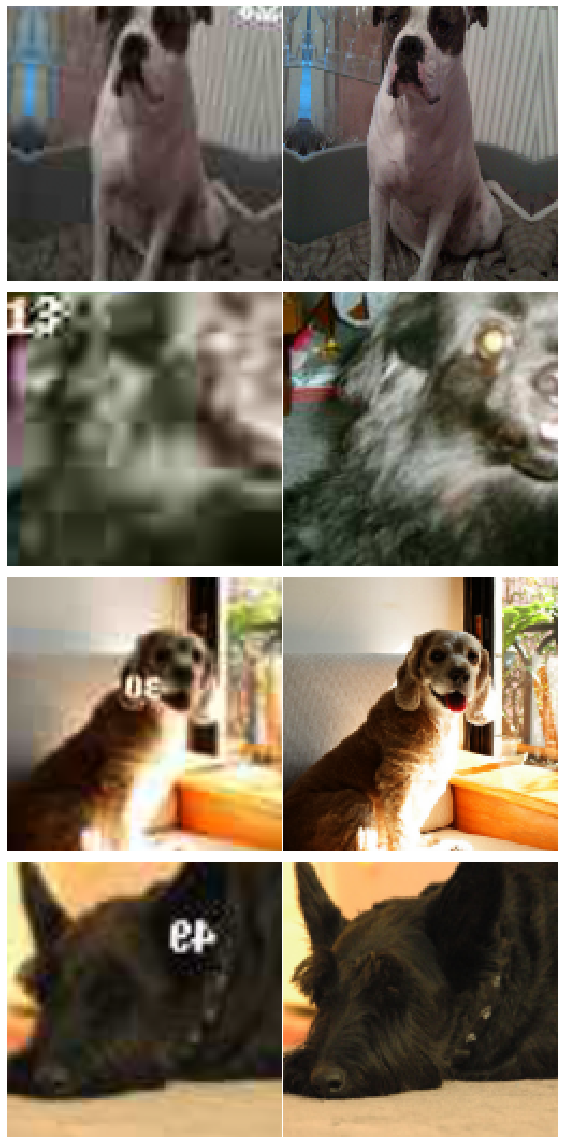

In [7]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom = 2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

data_gen = get_data(bs, size)
data_gen.show_batch(4)

In [8]:
wd = 1e-3
y_range = (-3., 3.)
loss_gen = MSELossFlat()  # MSE损失函数：均方差损失函数

def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight, self_attention=True, y_range=y_range, loss_func=loss_gen)

learn_gen = create_gen_learner()
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.068098,0.053995,02:42
1,0.053699,0.048747,02:30


In [9]:
# 解冻，再训练
learn_gen.unfreeze()
learn_gen.fit_one_cycle(3, slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,time
0,0.051566,0.049280,02:33
1,0.048914,0.045740,02:35
2,0.048173,0.044893,02:34


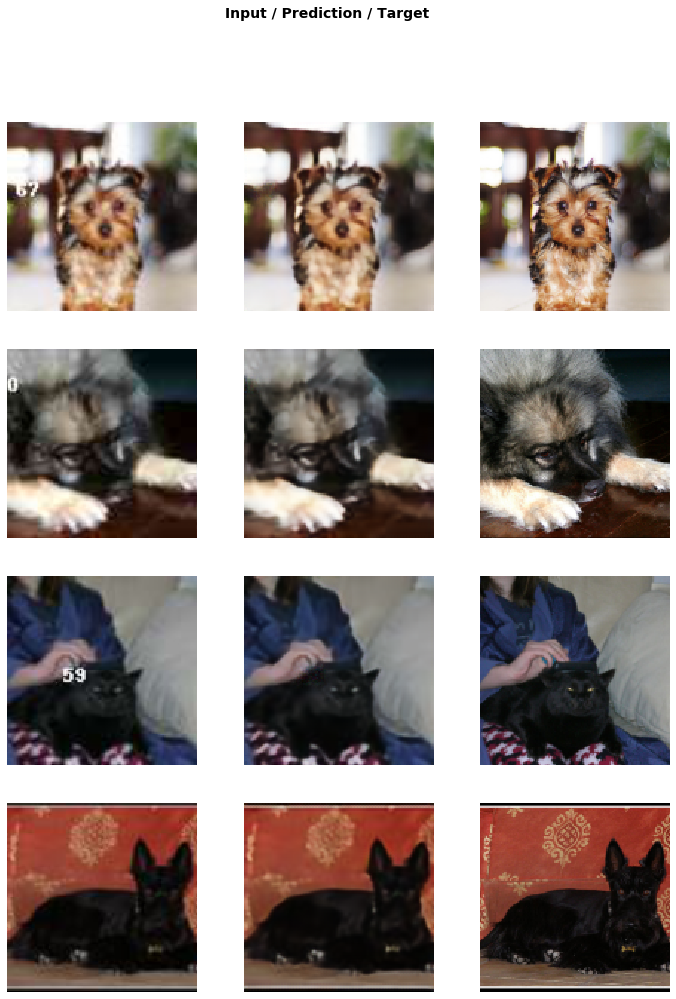

In [10]:
learn_gen.show_results(rows=4)

In [11]:
learn_gen.save('gen-pre2')

### Save generated images

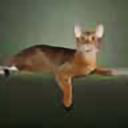

In [12]:
learn_gen.load('gen-pre2')
name_gen = 'image_gen'
path_gen = path/name_gen
#shutil.rmtree(path_gen)
path_gen.mkdir(exist_ok=True)

def save_preds(dl):
    i = 0
    names = dl.dataset.items
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)    # 把预测试保存
            i += 1

save_preds(data_gen.fix_dl)

PIL.Image.open(path_gen.ls()[0])

### Train critic  训练判别器（创建一个标准的二分类器）

In [13]:
# 如果不想重启jupyter，可以用这两行回收GPU内存
learn_gen = None
gc.collect()

35

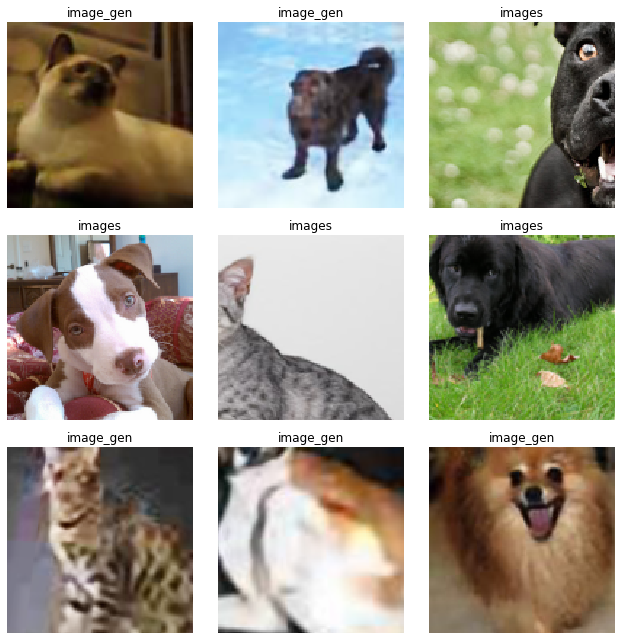

In [14]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size).databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [15]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())  # Binary Cross Entropy

def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)
learn_critic.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.614741,0.559272,0.716923,04:52
1,0.300185,0.182410,0.935271,04:38
2,0.158144,0.123842,0.974758,04:37
3,0.079491,0.079865,0.972821,04:37
4,0.045040,0.039117,0.988604,04:37
5,0.034632,0.037258,0.989259,04:38


In [16]:
learn_critic.save('critic-pre2')

### GAN

In [17]:
learn_crit = None
learn_gen = None
gc.collect()

44

In [18]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')   # 加载判别器
learn_gen = create_gen_learner().load('gen-pre2')                                 # 加载生成器

In [19]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1., 50.), show_img=False, switcher=switcher, opt_func=partial(optim.Adam, betas=(0., 0.99)), wd=wd)  # 传入生成器和判别器
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))
lr = 1e-4
learn.fit(40, lr)
learn.save('gan-1c')

epoch,train_loss,valid_loss,gen_loss,disc_loss,time


RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 6.00 GiB total capacity; 4.01 GiB already allocated; 0 bytes free; 183.78 MiB cached)

In [ ]:
learn.data = get_data(16, 192)
learn.fit(10, lr/2)
learn.show_results(rows=16)
learn.save('gan-1c')